In [35]:
from cvxopt import matrix, solvers
import time

# Hungarian method
from scipy.optimize import linear_sum_assignment

In [16]:
solvers.options['show_progress'] = False
def opt_lp(a, b, a_vec=None, b_vec=None, C=None):
    n, m = len(a), len(b)
    if C is None:
        if len(a_vec.shape) == 1:
            C =  np.sqrt((vecs_a[:,np.newaxis] - vecs_b)**2)
        else:
            distances_sq = (vecs_a[:,np.newaxis] - vecs_b)**2
            C = np.sqrt(distances_sq.sum(-1))
    c = C.flatten('F')
    A = np.vstack([np.kron(np.eye(n), np.ones(m)[np.newaxis,:]),
               np.kron(np.ones(n)[np.newaxis,:], np.eye(m))])
    
    c_mat = matrix(c)
    A_mat = matrix(A[:-1,:])
    b_mat = matrix(np.concatenate([a,b])[:-1])
    G_mat = matrix(-np.eye(n*m))
    h_mat = matrix(np.zeros(n*m))
    
    sol = solvers.lp(c_mat, G_mat, h_mat, A=A_mat, b=b_mat)
    return sol

In [12]:
n = 10

In [13]:
C = np.random.chisquare(1, size=(n,n))

In [14]:
linear_sum_assignment(C)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1, 5, 7, 6, 9, 4, 0, 2, 8, 3]))

# Hungarian

In [69]:
times = []
n_vals = range(100,1000,50)

for n in tqdm(n_vals):
    C = np.random.chisquare(1, size=(n,n))
    
    start = time.time()
    linear_sum_assignment(C)
    end = time.time()
    
    dt = end - start
    
    times.append(dt)

hungarian_times = pd.Series(times, index=n_vals)
hungarian_df = pd.DataFrame(hungarian_times).reset_index()
hungarian_df.columns = ['n', 'time']

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

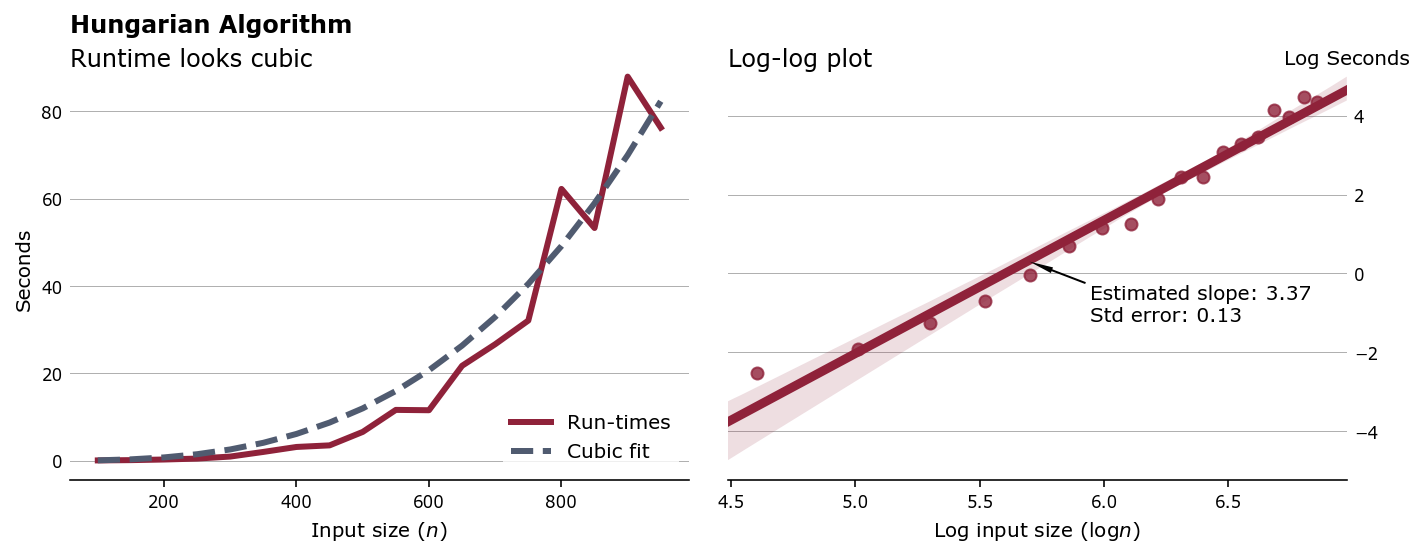

In [186]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(hungarian_times, label='Run-times')
plt.plot(hungarian_df.n, 9.602e-08  * hungarian_df.n**3, '--', label='Cubic fit')
plt.legend(loc='lower right')
plt.ylabel("Seconds")
plt.xlabel("Input size ($n$)")
artists1 = ft_ax(title="Hungarian Algorithm", left_axis=True, subtitle='Runtime looks cubic', yy=1.01)

plt.subplot(122)
sns.regplot(np.log(hungarian_df.n), np.log(hungarian_df.time), ax=plt.gca())
plt.annotate('Estimated slope: 3.37\nStd error: 0.13', xy=(5.7,0.3), xytext=(30,-30), textcoords='offset points',
             arrowprops={'width': 1, 'headwidth': 3, 'color': 'k'})
plt.ylabel("Log Seconds")
plt.xlabel("Log input size ($\log n$)")
artists = ft_ax(title=r"", subtitle='Log-log plot', yy=1.02)
plt.savefig('hungarianlog.pdf', bbox_inches='tight', bbox_extra_artists=artists)

plt.savefig('hungarianruntime.pdf', bbox_inches='tight', bbox_extra_artists=artists)

In [61]:
hungarian_df.dtypes

n         int64
time    float64
dtype: object

In [95]:
print(smf.ols('time ~ np.power(n,3) + 0', data=hungarian_df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     429.0
Date:                Wed, 28 Mar 2018   Prob (F-statistic):           1.69e-13
Time:                        14:47:59   Log-Likelihood:                -60.446
No. Observations:                  18   AIC:                             122.9
Df Residuals:                      17   BIC:                             123.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
np.power(n, 3)  9.602e-08   4.64e-09     20.

/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


In [72]:
print(smf.ols('np.log(time) ~ np.log(n)', data=hungarian_df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(time)   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     693.1
Date:                Wed, 28 Mar 2018   Prob (F-statistic):           1.33e-14
Time:                        14:40:18   Log-Likelihood:                -5.3077
No. Observations:                  18   AIC:                             14.62
Df Residuals:                      16   BIC:                             16.40
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -18.9241      0.787    -24.051      0.0

/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


# LP

In [111]:
times = []
n_vals = range(1,51,1)

for n in tqdm(n_vals):
    C = np.random.chisquare(1, size=(n,n))
    
    start = time.time()
    opt_lp(np.ones(n)/n, np.ones(n)/n, C=C)
    end = time.time()
    
    dt = end - start
    
    times.append(dt)

lp_times = pd.Series(times, index=n_vals)
lp_df = pd.DataFrame(lp_times).reset_index()
lp_df.columns = ['n', 'time']

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

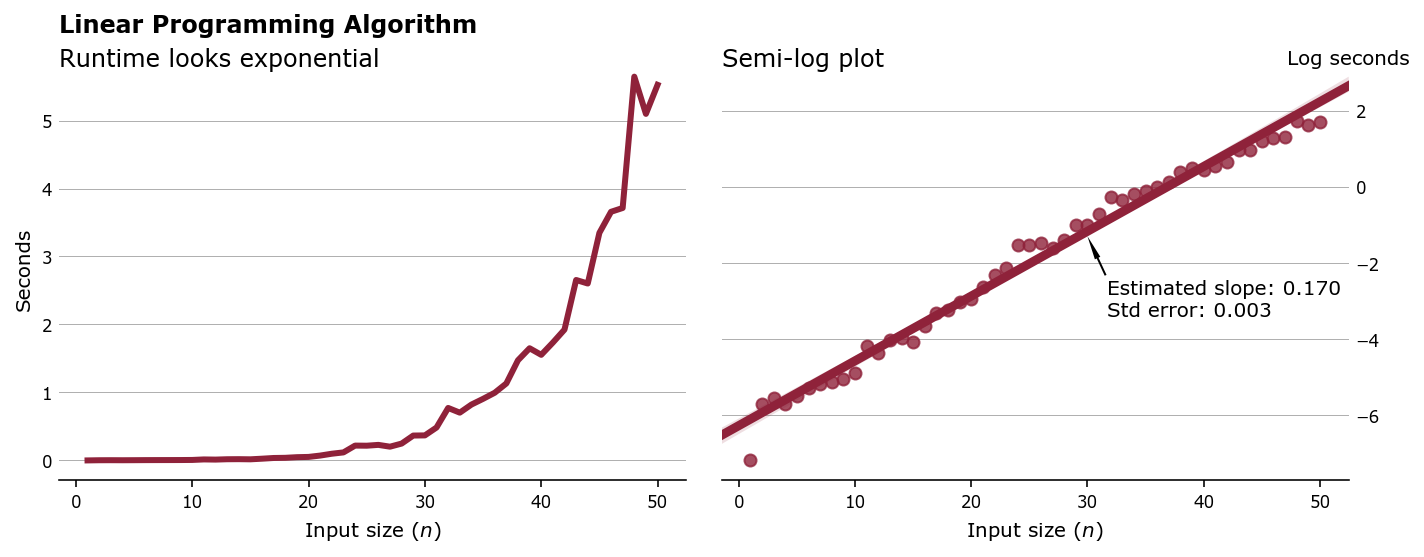

In [187]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(lp_times)
plt.xlabel('Input size ($n$)')
plt.ylabel('Seconds')
artists1 = ft_ax(title="Linear Programming Algorithm", subtitle='Runtime looks exponential', add_box=False, left_axis=True)
plt.subplot(122)
sns.regplot(lp_df.n, np.log(lp_df.time), ax=plt.gca())
plt.annotate('Estimated slope: 0.170\nStd error: 0.003', xy=(30,-1.3), xytext=(10,-40), textcoords='offset points',
            arrowprops={'width': 1, 'headwidth': 3, 'color': 'k'})
plt.xlabel(r'Input size ($n$)')
plt.ylabel('Log seconds')
artists2 = ft_ax(title='', subtitle='Semi-log plot', yy=1.02)
plt.savefig('lpruntime.pdf', bbox_inches='tight', bbox_extra_artists=artists1+artists2)

In [156]:
print(smf.ols('np.log(time) ~ n', data=lp_df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(time)   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     3227.
Date:                Wed, 28 Mar 2018   Prob (F-statistic):           1.11e-45
Time:                        17:28:15   Log-Likelihood:                -10.696
No. Observations:                  50   AIC:                             25.39
Df Residuals:                      48   BIC:                             29.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.2766      0.088    -71.467      0.0